# Diabetes Model Classification Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# Functions

In [10]:
def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [3]:
df = pd.read_csv("Training.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
2455,3,126,88,41,235,39.3,0.704,27,0
2456,4,123,62,0,0,32.0,0.226,35,1
2457,1,80,74,11,60,30.0,0.527,22,0
2458,1,96,64,27,87,33.2,0.289,21,0


In [4]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [6]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Over 2000 duplicate rows

In [7]:
df.duplicated().sum()

2000

## Checking shape of classification column

In [8]:
print(df.shape)
# summarize the class distribution
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
  per = v / len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(2460, 9)
Class=1, Count=960, Percentage=39.024%
Class=0, Count=1500, Percentage=60.976%


##### Fairly Balanced dataset

# Visuals

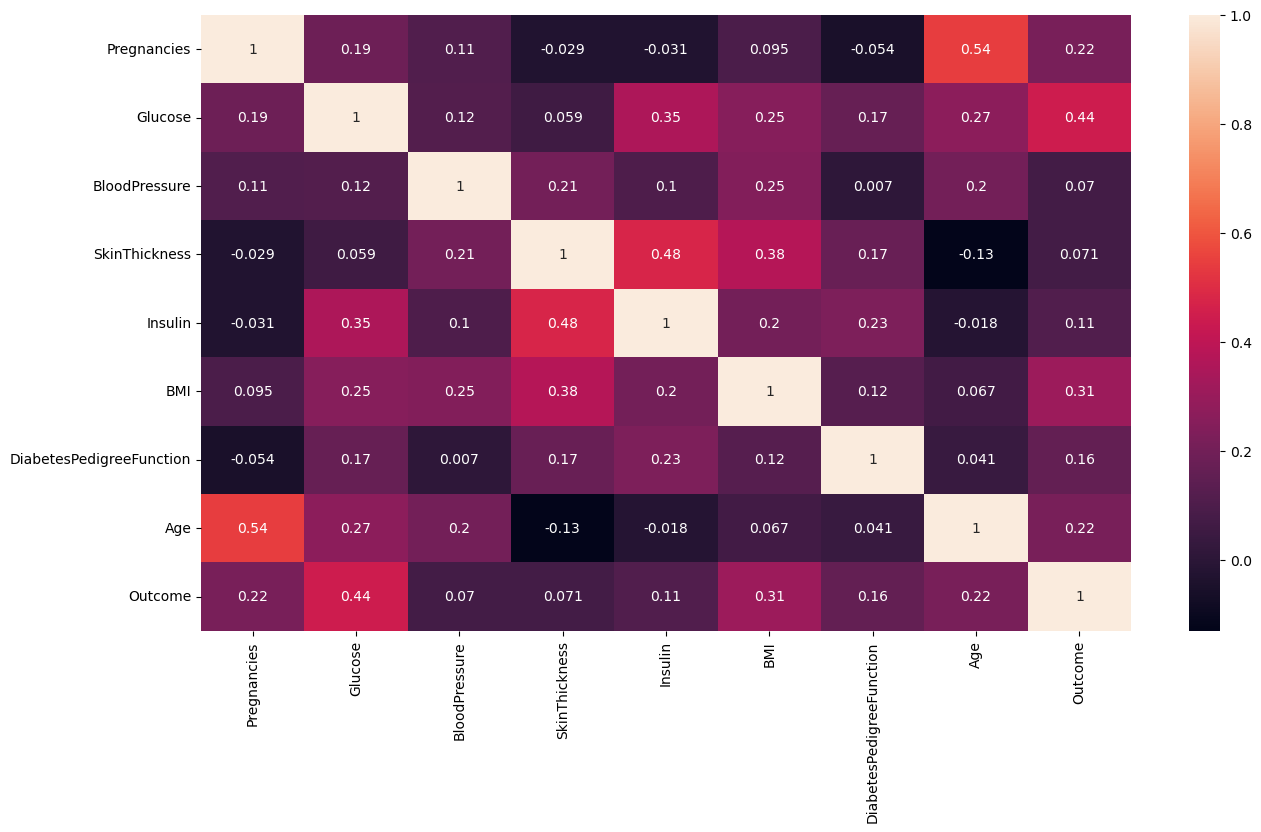

In [9]:
relations = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(data=relations, annot=True)
plt.show()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1443621820.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1443621820.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1443621820.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1443621820.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1443621820.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1443621820.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/14436

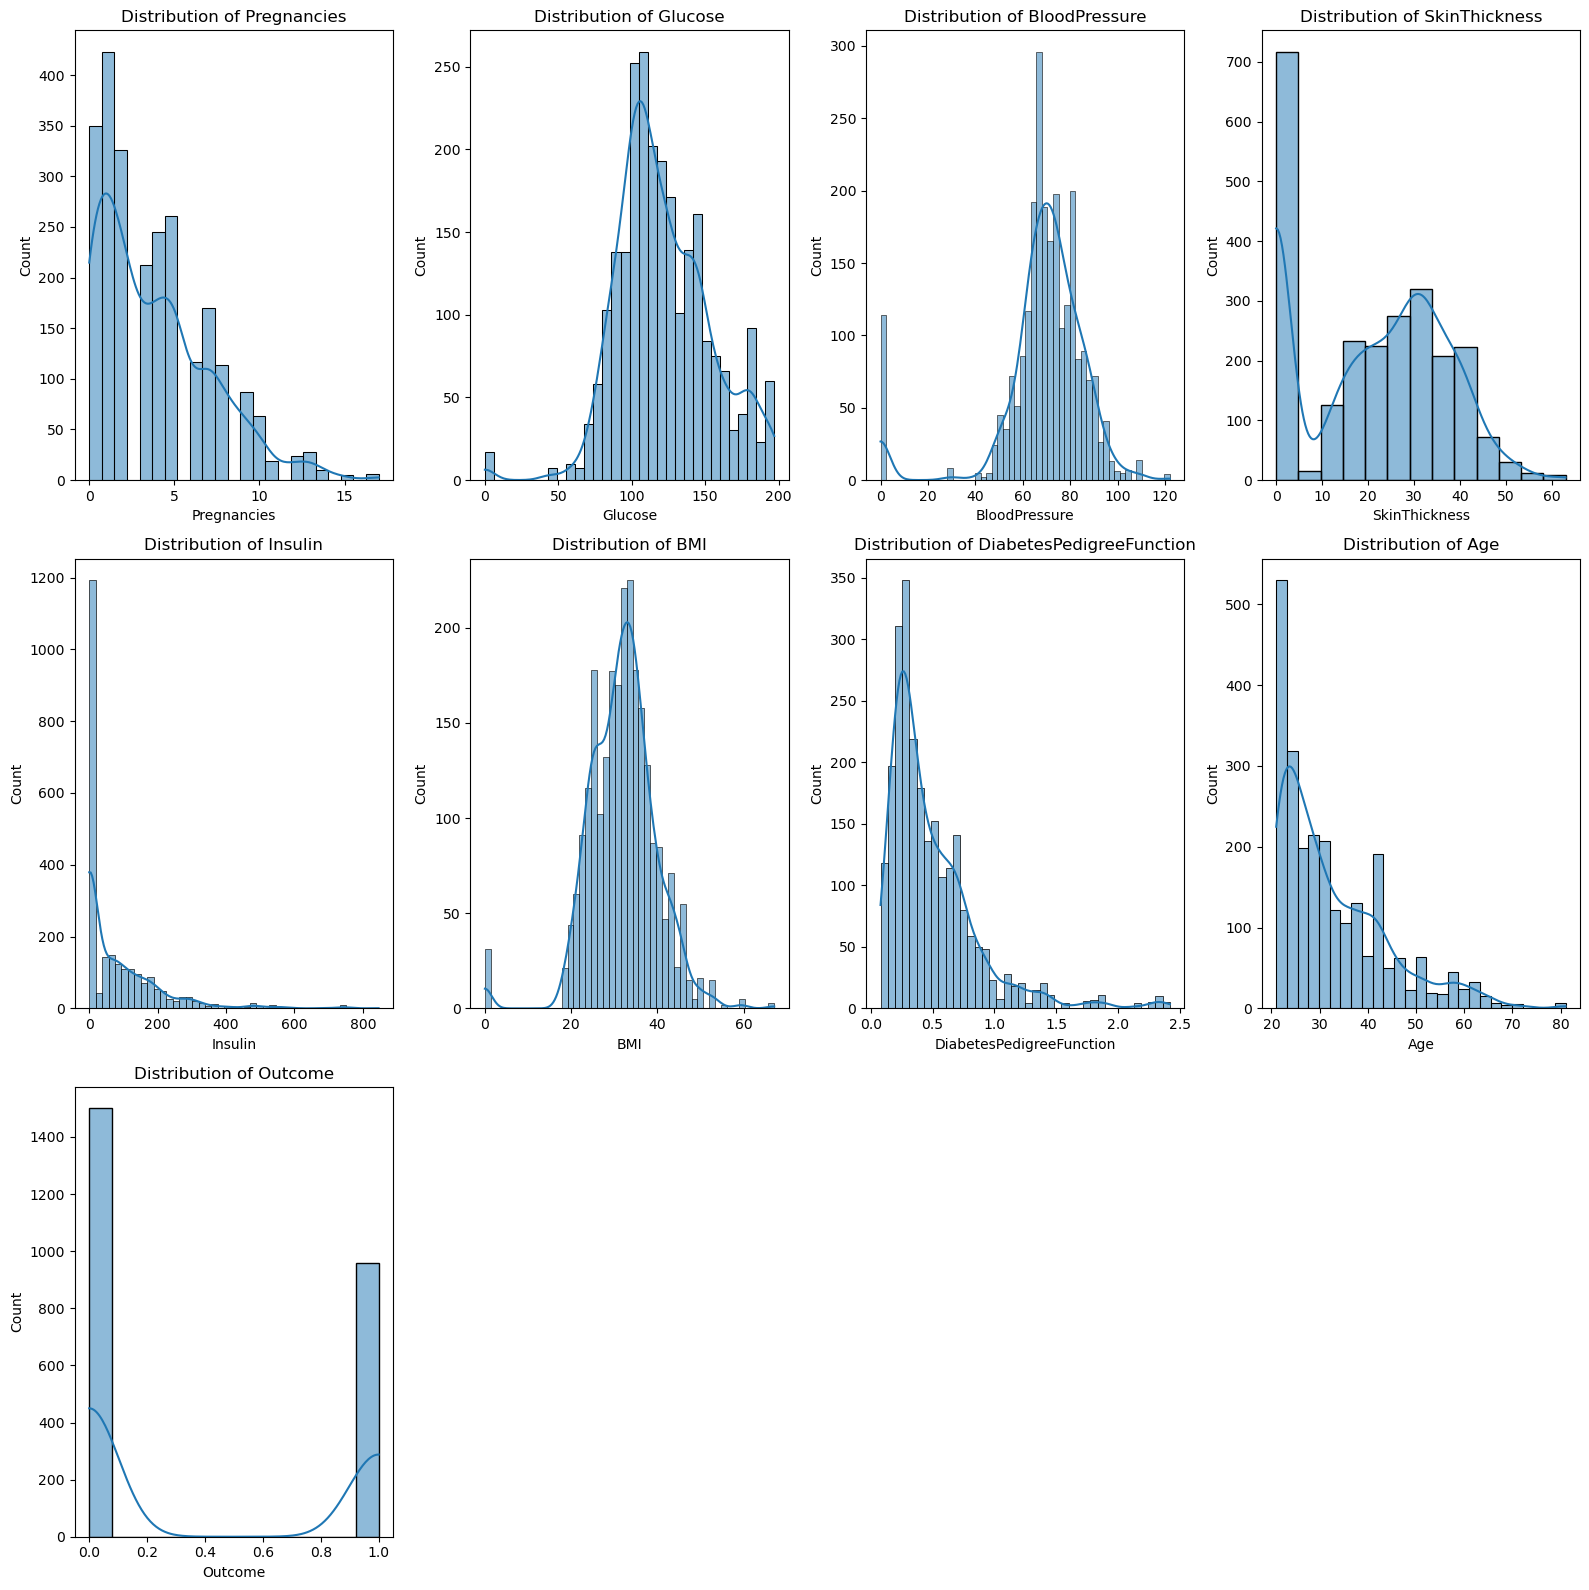

In [13]:
plt.figure(figsize=(16,16))
num_cols = len(df.columns)
rows = (num_cols +3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(rows,4,idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1367440120.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1367440120.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1367440120.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1367440120.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1367440120.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/1367440120.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_37080/13674

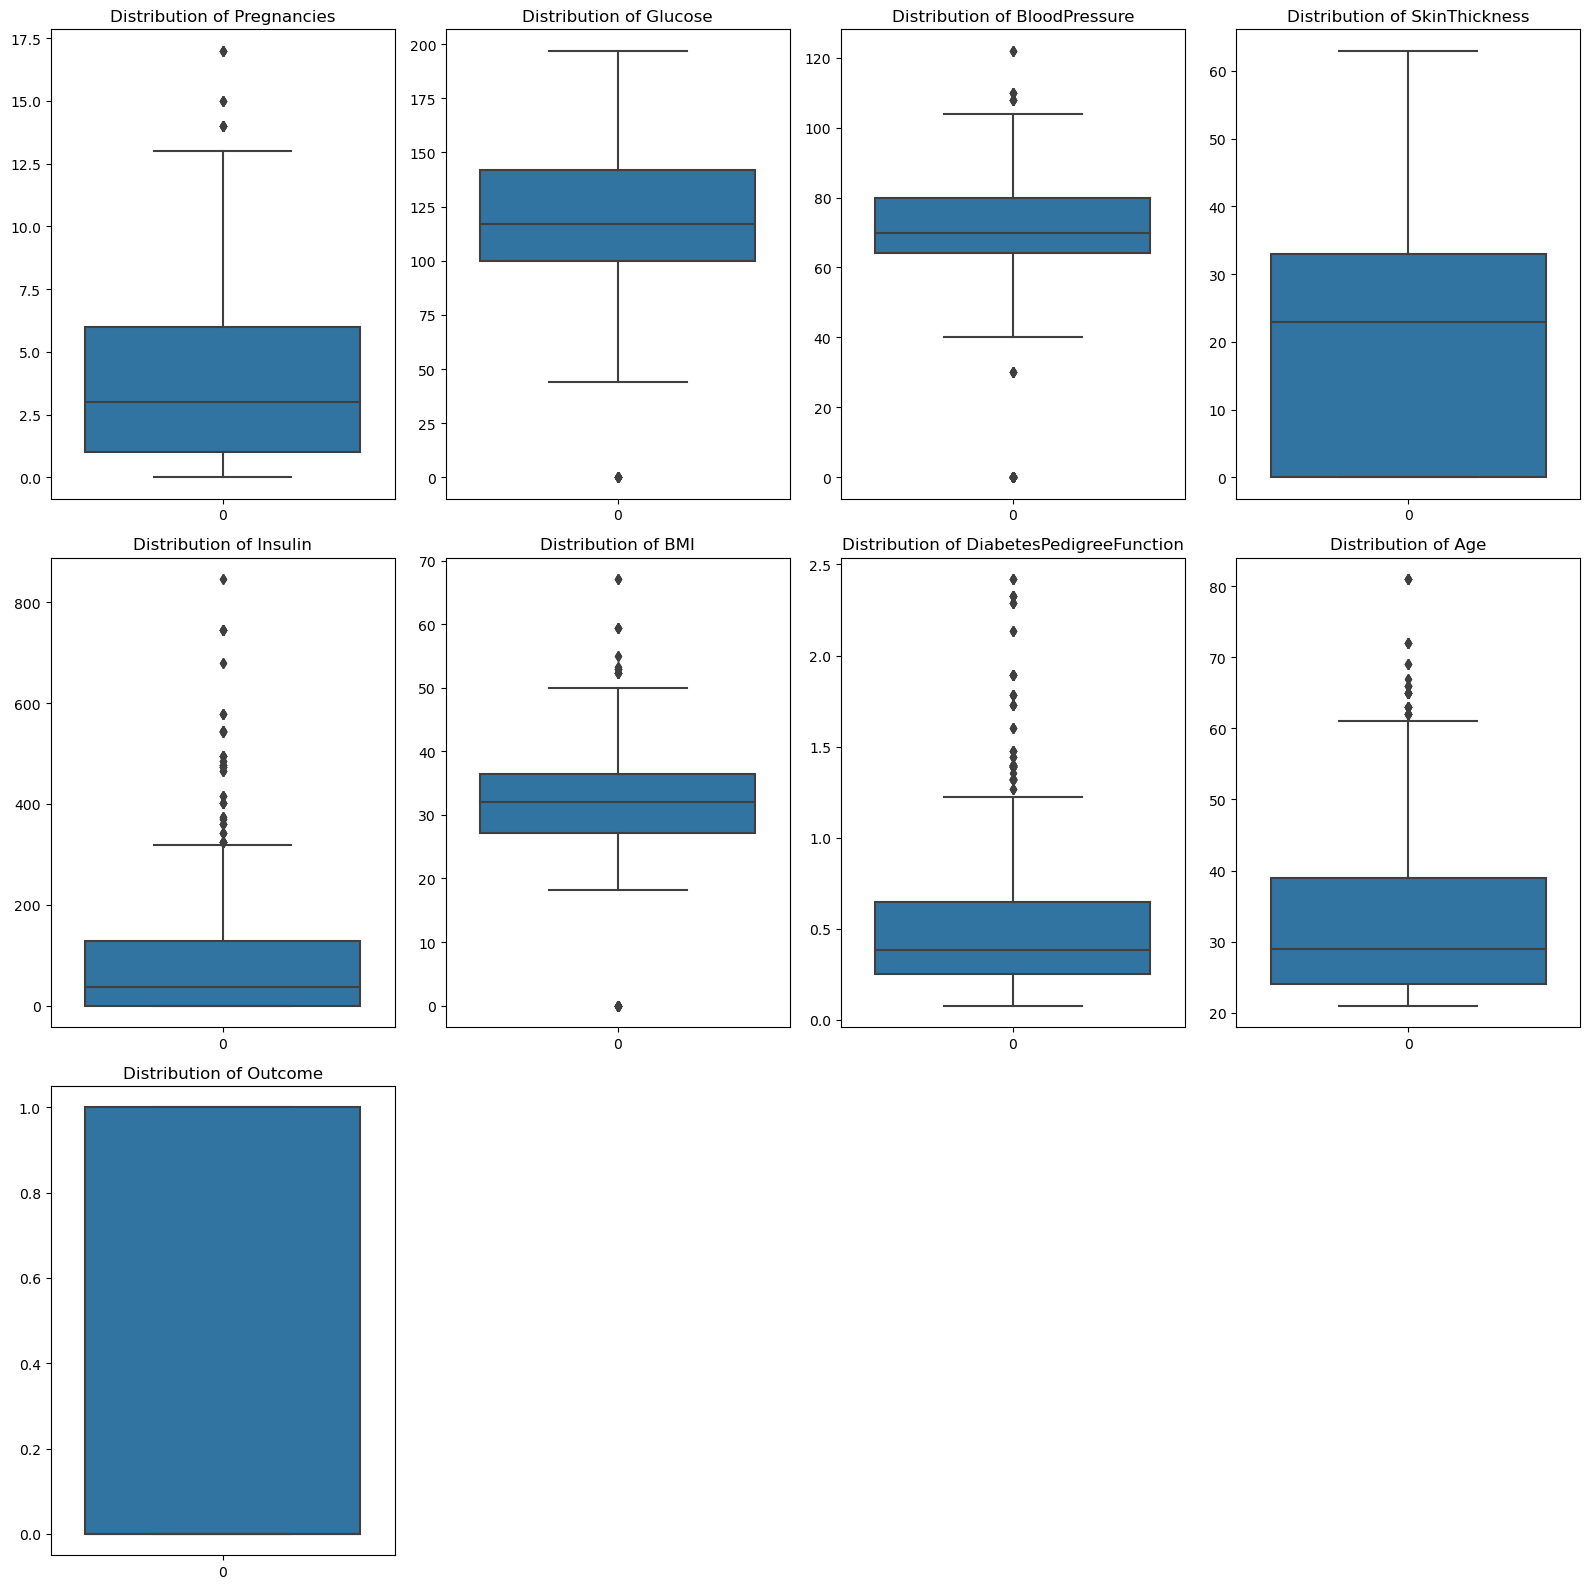

In [14]:
plt.figure(figsize=(16,16))
num_cols = len(df.columns)
rows = (num_cols +3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(rows,4,idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

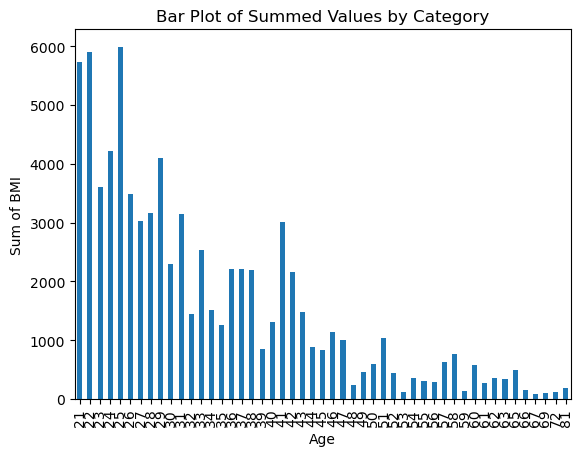

In [22]:
grouped_df = df.groupby("Age")["BMI"].sum().reset_index()

grouped_df.plot(kind='bar', x='Age', y='BMI', legend=False)
plt.xlabel('Age')
plt.ylabel('Sum of BMI')
plt.title('Bar Plot of Summed Values by Category')
plt.show()

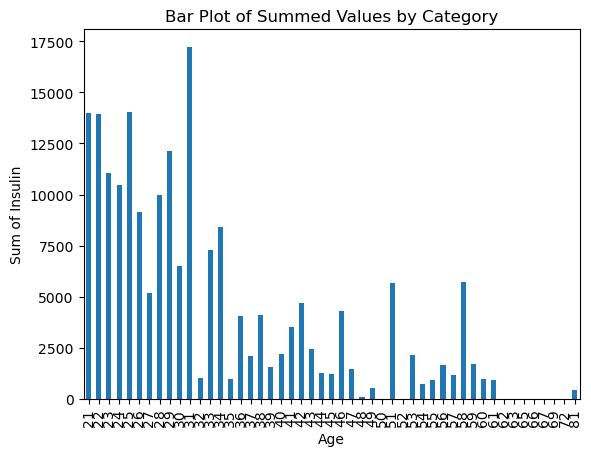

In [23]:
grouped_df = df.groupby("Age")["Insulin"].sum().reset_index()

grouped_df.plot(kind='bar', x='Age', y='Insulin', legend=False)
plt.xlabel('Age')
plt.ylabel('Sum of Insulin')
plt.title('Bar Plot of Summed Values by Category')
plt.show()

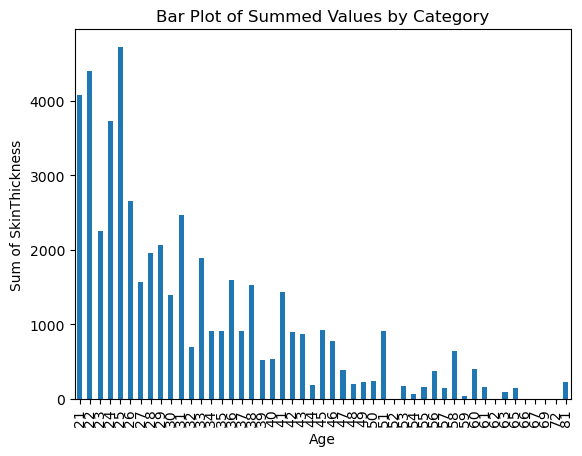

In [25]:
grouped_df = df.groupby("Age")["SkinThickness"].sum().reset_index()

grouped_df.plot(kind='bar', x='Age', y='SkinThickness', legend=False)
plt.xlabel('Age')
plt.ylabel('Sum of SkinThickness')
plt.title('Bar Plot of Summed Values by Category')
plt.show()

# Baseline Model Performance

In [26]:
def f1_multiclass(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(f1_multiclass)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='uniform')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F1: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

(2460, 8) (2460,) Counter({0: 1500, 1: 960})
Mean F1: 0.489 (0.026)


### Baseline model tells us that a mean of about 0.49% is what we should do strive to do better than

# Model Evaluation

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
models = run_all_models(X_train, X_test, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024-03-31 09:12:46.332344: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 401us/step - loss: 0.4811 - accuracy: 0.7622


,Model,Accuracy
2,DecisionTreeClassifier,0.997967
3,RandomForestClassifier,0.997967
8,GPC,0.997967
4,KNeighborsClassifier,0.943089
5,GradientBoostingClassifier,0.924797
9,Sequential,0.762195
1,SVC,0.731707
0,LogisticRegression,0.729675
7,LDA,0.725610
6,GaussianNB,0.717480


In [28]:
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = run_all_models(X_train_scaled, X_test_scaled, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

16/16 [==============================] - 0s 427us/step - loss: 0.0307 - accuracy: 0.9980


,Model,Accuracy
9,Sequential,0.997967
2,DecisionTreeClassifier,0.997967
3,RandomForestClassifier,0.997967
4,KNeighborsClassifier,0.934959
8,GPC,0.932927
5,GradientBoostingClassifier,0.924797
1,SVC,0.823171
0,LogisticRegression,0.729675
7,LDA,0.725610
6,GaussianNB,0.717480


### 99% Accuracy likely tell us that our model is overfitting due to duplicates in the data set

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer


def f1_multiclass(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(f1_multiclass)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

# define models to test
def get_models():
  models, names = list(), list()
  # DTC
  models.append(DecisionTreeClassifier()) 
  names.append('DTC')
  # NB
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  return models, names

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # Wrap the model in a pipeline with StandardScaler
  pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
  # Evaluate the model
  scores = evaluate_model(X, y, pipeline)  # Replace X, y with your data
  results.append(scores)
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>DTC 0.998 (0.004)
>RFC 0.999 (0.002)
>GBC 0.918 (0.020)
>KNN 0.954 (0.014)


#### High Average mean and low std represents model stability, however this is likely due to duplicate data

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer


# evaluate a model
def evaluate_model(X_train, X_test, y_train, y_test, model):
  
  model.fit(X_train, y_train)
  yhat = model.predict(X_test)
  
  conf_matrix = confusion_matrix(y_test, yhat)
  class_report = classification_report(y_test,yhat)
  accuracy = accuracy_score(y_test, yhat)
  
  return conf_matrix, class_report, accuracy

# define models to test
def get_models():
  models, names = list(), list()
  # DTC
  models.append(DecisionTreeClassifier()) 
  names.append('DTC')
  # NB
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  return models, names

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
# evaluate each model
for i in range(len(models)):
  # Wrap the model in a pipeline with StandardScaler
  pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
  # Evaluate the model
  conf_matrix, class_report, accuracy = evaluate_model(X_train, X_test, y_train, y_test, pipeline) 
  # Print results
  print(f"Model: {names[i]}")
  print("\nClassification Report:\n", class_report)
  print("\nAccuracy:", accuracy)
  print("------------------------")

Model: DTC

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       305
           1       1.00      0.99      1.00       187

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492


Accuracy: 0.9979674796747967
------------------------
Model: RFC

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       305
           1       1.00      0.99      1.00       187

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492


Accuracy: 0.9979674796747967
------------------------
Model: GBC

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       305
           1       

Model: DTC, Accuracy: 0.999, F1 Score: 0.999


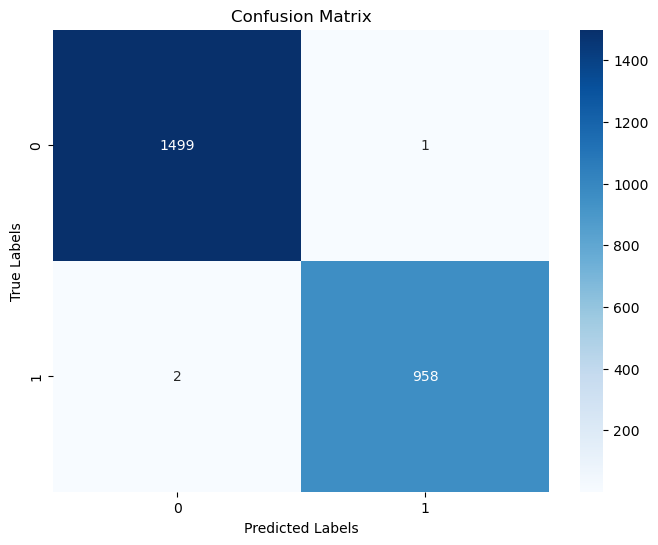

Model: RFC, Accuracy: 0.999, F1 Score: 0.999


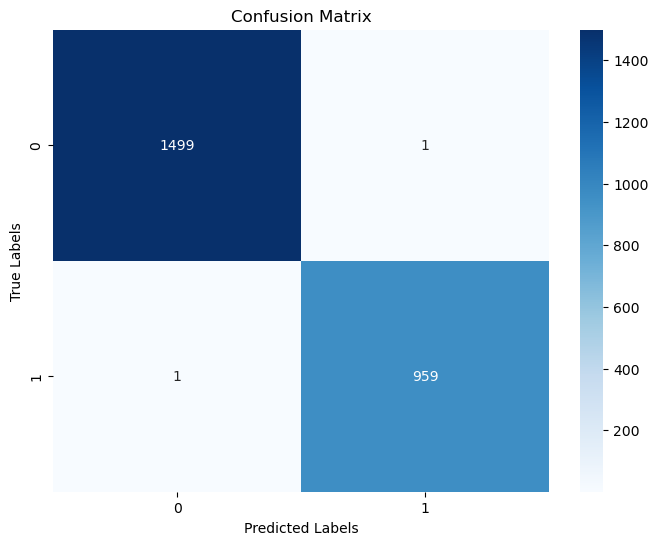

Model: GBC, Accuracy: 0.923, F1 Score: 0.919


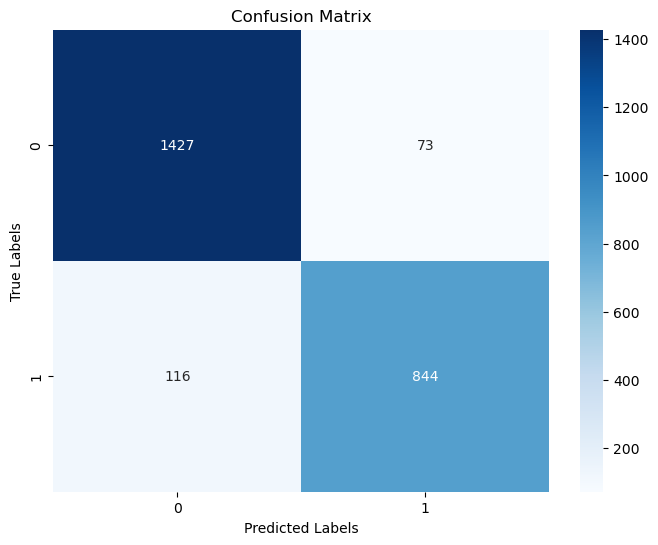

Model: KNN, Accuracy: 0.959, F1 Score: 0.958


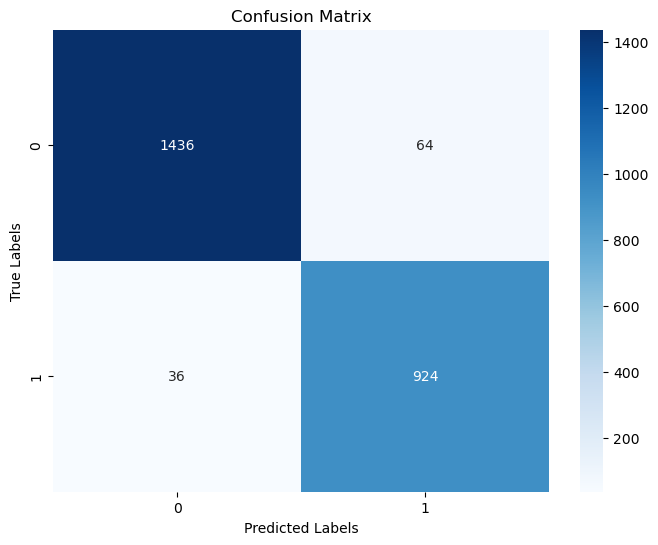

  Model  Accuracy  F1 Score
0   DTC  0.998780  0.998719
1   RFC  0.999187  0.999146
2   GBC  0.923171  0.918599
3   KNN  0.959350  0.957509


In [33]:
from sklearn.calibration import cross_val_predict
# define models to test
def get_models():
  models, names = list(), list()
  # DTC
  models.append(DecisionTreeClassifier()) 
  names.append('DTC')
  # NB
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  return models, names

models, names = get_models()
model_performance = []
for i in range(len(models)):
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('power_transformer', PowerTransformer()), 
        ('model', models[i])
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=10) 

    # Compute the desired metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F1 Score": f1
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F1 Score: {f1:.3f}")
    
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Convert the model_performance to a DataFrame for easier analysis
performance_df = pd.DataFrame(model_performance)
print(performance_df)

#### RFC model has the highest performance, however these results raise suspicion

# Refactor Data Analysis

In [34]:
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Testing.csv')

In [35]:
test_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [36]:
test_df.duplicated().sum()

0

In [37]:
train_df.drop_duplicates(inplace=True)

In [38]:
train_df.duplicated().sum()

0

In [40]:
print(train_df.shape)
# summarize the class distribution
target = train_df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
  per = v / len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(460, 9)
Class=1, Count=175, Percentage=38.043%
Class=0, Count=285, Percentage=61.957%


In [41]:
print(test_df.shape)
# summarize the class distribution
target = test_df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
  per = v / len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(308, 9)
Class=0, Count=215, Percentage=69.805%
Class=1, Count=93, Percentage=30.195%


# Data Preparation

In [42]:
X_train = train_df.drop('Outcome', axis=1)
y_train = train_df['Outcome']

X_test = test_df.drop('Outcome', axis=1)
y_test = test_df['Outcome']

# Re-Model-Evaluation

In [43]:
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = run_all_models(X_train_scaled, X_test_scaled, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

10/10 [==============================] - 0s 472us/step - loss: 0.5509 - accuracy: 0.7922


,Model,Accuracy
3,RandomForestClassifier,0.824675
1,SVC,0.811688
0,LogisticRegression,0.808442
7,LDA,0.805195
5,GradientBoostingClassifier,0.792208
9,Sequential,0.792208
6,GaussianNB,0.788961
8,GPC,0.788961
4,KNeighborsClassifier,0.750000
2,DecisionTreeClassifier,0.707792


In [44]:
scaler = MinMaxScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = run_all_models(X_train_scaled, X_test_scaled, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

10/10 [==============================] - 0s 631us/step - loss: 0.4471 - accuracy: 0.8214


,Model,Accuracy
9,Sequential,0.821429
3,RandomForestClassifier,0.821429
1,SVC,0.811688
8,GPC,0.808442
7,LDA,0.805195
0,LogisticRegression,0.792208
5,GradientBoostingClassifier,0.792208
6,GaussianNB,0.788961
4,KNeighborsClassifier,0.746753
2,DecisionTreeClassifier,0.701299


# Advanced Modeling

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer


def f1_multiclass(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(f1_multiclass)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

# define models to test
def get_models():
  models, names = list(), list()
  # SVM
  models.append(SVC()) 
  names.append('SVM')
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # GPC
  models.append(GaussianProcessClassifier())
  names.append('GPC')
  # LDA
  models.append(LinearDiscriminantAnalysis())
  names.append('LDA')
  return models, names

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # Wrap the model in a pipeline with StandardScaler
  pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
  # Evaluate the model
  scores = evaluate_model(X_train, y_train, pipeline)  # Replace X, y with your data
  results.append(scores)
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>SVM 0.693 (0.070)
>RFC 0.695 (0.074)
>GBC 0.667 (0.072)
>LR 0.716 (0.083)
>GPC 0.693 (0.067)
>LDA 0.710 (0.084)
